In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import sbibm
from sbibm.tasks.gaussian_linear.task import GaussianLinear
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

sns.set(style="whitegrid", context="paper", font_scale=1.2)


Device: cpu


In [3]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [4]:
def sample_uniform_lhs(n_samples, dim, low=-1.0, high=1.0, device=device):
    """Generate uniform samples using Latin Hypercube Sampling"""
    sampler = qmc.LatinHypercube(d=dim, seed=42)
    u_samples = sampler.random(n_samples)
    # Transform from [0,1]^d to [low,high]^d
    samples = low + (high - low) * u_samples
    return torch.tensor(samples, dtype=torch.float32, device=device)

In [5]:
n_simulations = 4000

# Parameters ranges
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Task setup
task = GaussianLinear(
    dim=2, prior_scale=param_1_width/2
)
simulator = task.get_simulator()

# Prior and posterior
prior = ili.utils.IndependentNormal(
    loc = [param_1_width/2, param_2_width/2],
    scale = sigmas, device=device)

# Create the old proposal distribution
# Using Uniform distribution for the old proposal
proposal_old = ili.utils.Uniform(
    low=[param_1_range[0], param_2_range[0]], 
    high=[param_1_range[1], param_2_range[1]], 
    device=device)

# Create the TailedNormal distribution
proposal_new = TailedNormal(
    a = torch.tensor([param_1_range[0], param_2_range[0]], dtype=torch.float32),
    b = torch.tensor([param_1_range[1], param_2_range[1]], dtype=torch.float32),
    sigma = torch.tensor([sigmas[0], sigmas[1]], dtype=torch.float32),
)

# Sample from the old and new proposal distributions
# LHS
theta_old = sample_uniform_lhs(n_simulations, dim = 2, low=-1.0, high=1.0, device=device)
theta = proposal_new.sample_lhs(n_simulations)

# Run simulations for each parameter set
x_old = simulator(theta_old)
x = simulator(theta)

In [6]:
# Get true posterior for simulated observations
ref_posteriors = [] # Initialize list to store posterior samples
n_posterior_samples = n_simulations

for i in range(n_simulations):
   xobs = x[i:i+1] # Keep batch dimension
   ref_new = task._get_reference_posterior(observation=xobs)
   samples = ref_new.sample((n_posterior_samples,))
   ref_posteriors.append(samples)

# Stack all samples
ref_posteriors = torch.stack(ref_posteriors)

Saved plot: toy-2-dim-figures/example-samples.png


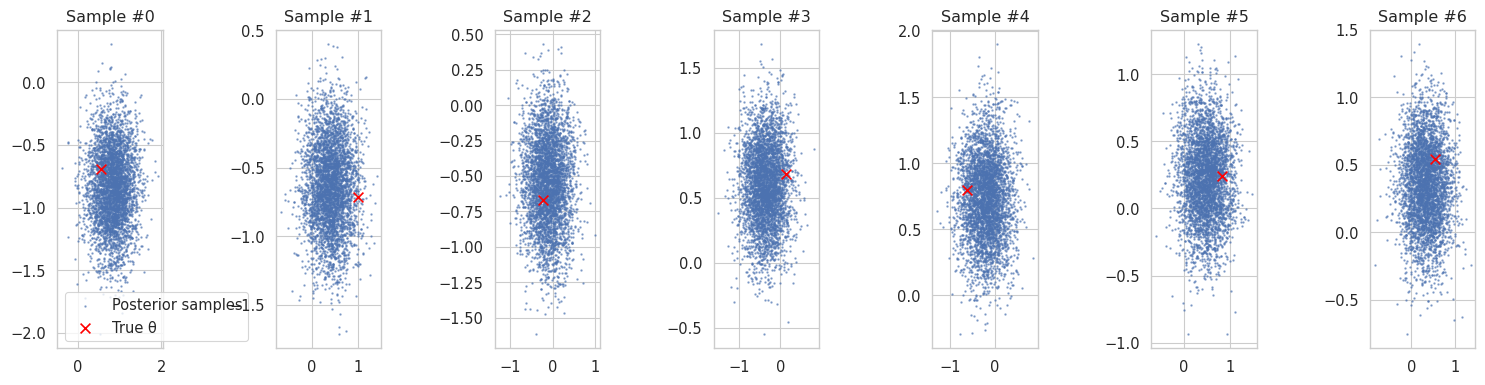

Checking if true parameters are covered by posteriors:
Sample 0: Covered: True
Sample 1: Covered: True
Sample 2: Covered: True
Sample 3: Covered: True
Sample 4: Covered: True
Sample 5: Covered: True
Sample 6: Covered: True


In [7]:
# Test with a few examples to verify correctness
n_test = 7

fig, axes = plt.subplots(1, n_test, figsize=(15, 4))

for i in range(n_test):
   axes[i].scatter(ref_posteriors[i, :, 0], ref_posteriors[i, :, 1], 
                  alpha=0.5, s=1, label='Posterior samples')
   axes[i].scatter(theta[i, 0], theta[i, 1], 
                  color='red', s=50, marker='x', label='True θ')
   axes[i].set_title(f'Sample #{i}')
   if i == 0:
       axes[i].legend()

plt.tight_layout()
# Save the figure
os.makedirs('toy-2-dim-figures', exist_ok=True)
filename = f'toy-2-dim-figures/example-samples.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()


# Check if true parameters are within posterior support
print("Checking if true parameters are covered by posteriors:")
for i in range(min(n_test, n_simulations)):
   post_min = ref_posteriors[i].min(dim=0)[0]
   post_max = ref_posteriors[i].max(dim=0)[0]
   covered = torch.all((theta[i] >= post_min) & (theta[i] <= post_max))
   print(f"Sample {i}: Covered: {covered}")

Saved plot: toy-2-dim-figures/parameter-space.png


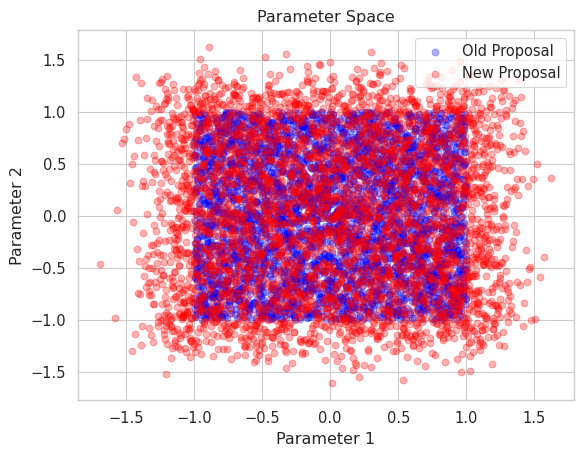

In [8]:
plt.scatter(theta_old[:, 0].cpu(), theta_old[:, 1].cpu(), c='blue', label='Old Proposal', alpha=0.3)
plt.scatter(theta[:, 0].cpu(), theta[:, 1].cpu(), c='red', label='New Proposal', alpha=0.3)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Parameter Space')
plt.legend()

filename = f'toy-2-dim-figures/parameter-space.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")

Saved plot: toy-2-dim-figures/parameter-space-posterior.png


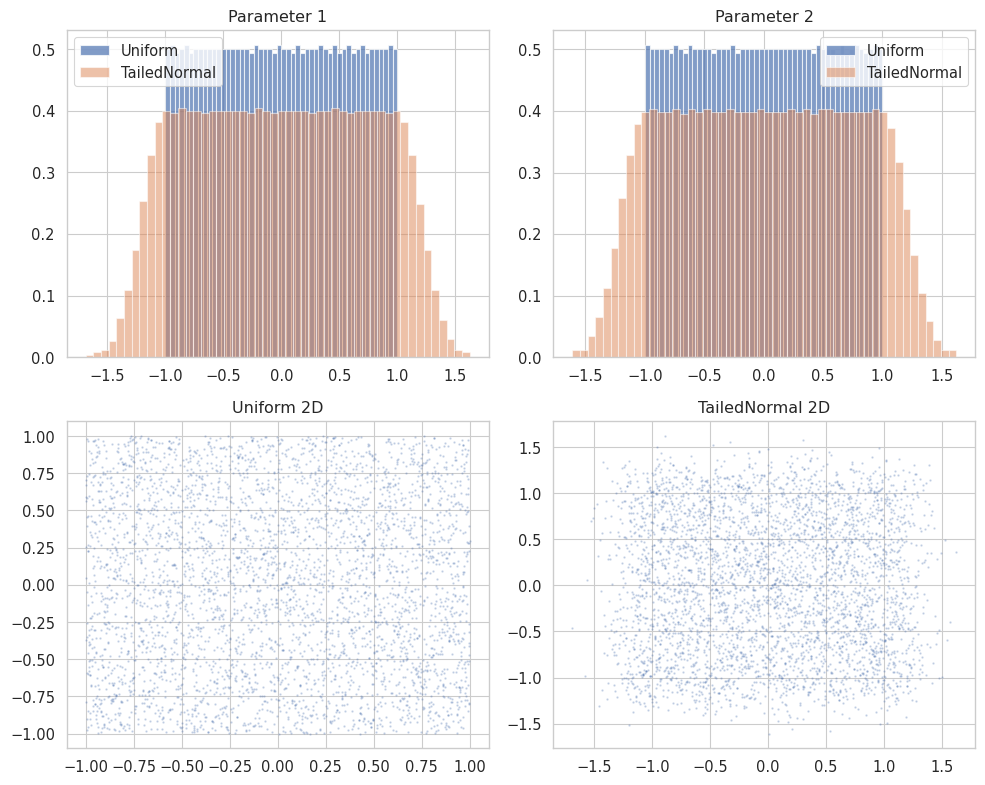

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Parameter 1
axes[0,0].hist(theta_old[:, 0], bins=50, alpha=0.7, label='Uniform', density=True)
axes[0,0].hist(theta[:, 0], bins=50, alpha=0.5, label='TailedNormal', density=True)
axes[0,0].set_title('Parameter 1')
axes[0,0].legend()

# Parameter 2
axes[0,1].hist(theta_old[:, 1], bins=50, alpha=0.7, label='Uniform', density=True)
axes[0,1].hist(theta[:, 1], bins=50, alpha=0.5, label='TailedNormal', density=True)
axes[0,1].set_title('Parameter 2')
axes[0,1].legend()

# 2D scatter plots
axes[1,0].scatter(theta_old[:, 0], theta_old[:, 1], alpha=0.2, s=1)
axes[1,0].set_title('Uniform 2D')

axes[1,1].scatter(theta[:, 0], theta[:, 1], alpha=0.2, s=1)
axes[1,1].set_title('TailedNormal 2D')

plt.tight_layout()

filename = f'toy-2-dim-figures/parameter-space-posterior.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")

In [10]:
# Create dataloaders
loader_old = NumpyLoader(x=x_old, theta=theta_old)
loader = NumpyLoader(x=x, theta=theta)

# Instantiate neural networks for ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=16, num_transforms=5,),
    ili.utils.load_nde_sbi(engine='NPE', model='made', hidden_features=16, num_transforms=5,)
]

# Define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 5e-5
}

# Initialize the trainers
os.makedirs('toy-2-dim-models', exist_ok=True)
runner_old = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=proposal_old,
    out_dir='toy-2-dim-models/uniform'
)

runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=proposal_new,
    out_dir='toy-2-dim-models/taileduniform'
)

In [11]:
posterior_ensemble_old, summaries_old = runner_old(loader=loader_old)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/sbi/inference/snpe/snpe_base.py:601: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(
INFO:root:Training model 1 / 2.


Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 122

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 123 epochs.Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 116

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 118.17221665382385 seconds to train models.
INFO:root:Saving model to toy-2-dim-models/uniform


 Neural network successfully converged after 117 epochs.

In [12]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 123

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 124 epochs.Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 109

INFO:root:It took 116.5164065361023 seconds to train models.
INFO:root:Saving model to toy-2-dim-models/taileduniform


 Neural network successfully converged after 110 epochs.

Saved plot: toy-2-dim-figures/train-and-val.png


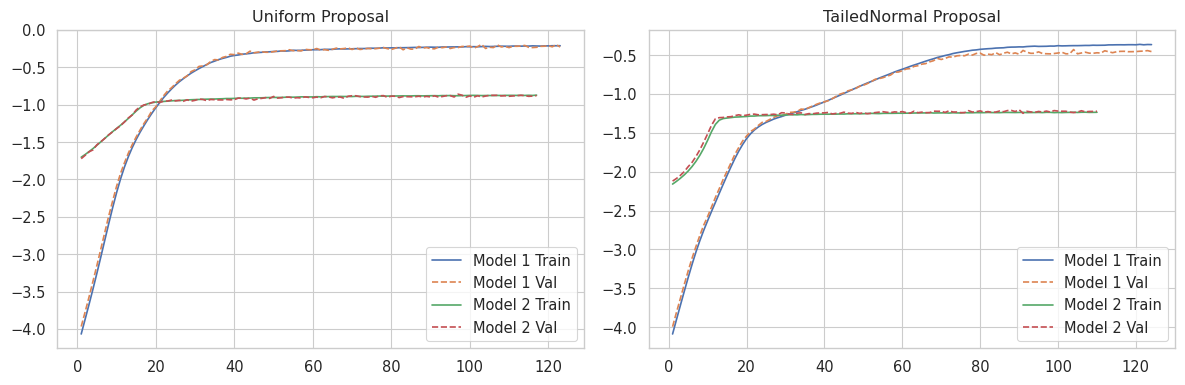

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Uniform proposal
for i, summary in enumerate(summaries_old):
   train_logprob = -1.0 * np.array(summary['training_loss'])
   val_logprob = -1.0 * np.array(summary['validation_loss'])
   epochs = np.arange(1, len(train_logprob) + 1)
   axes[0].plot(epochs, train_logprob, label=f"Model {i+1} Train")
   axes[0].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[0].set_title('Uniform Proposal')
axes[0].legend()

# TailedNormal proposal  
for i, summary in enumerate(summaries):
   train_logprob = -1.0 * np.array(summary['training_loss'])
   val_logprob = -1.0 * np.array(summary['validation_loss'])
   epochs = np.arange(1, len(train_logprob) + 1)
   axes[1].plot(epochs, train_logprob, label=f"Model {i+1} Train")
   axes[1].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[1].set_title('TailedNormal Proposal')
axes[1].legend()

plt.tight_layout()
filename = f'toy-2-dim-figures/train-and-val.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()